In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Step 1: Load the RefFlat Gene Annotation File ─────────────────────────────
ref = pd.read_csv("refFlat", sep="\t", header=None)

# Add column names (adjust if your version differs):
ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# ─── Step 2: Extract the Strand-Aware TSS ───────────────────────────────────────
# On “+” strand the 5′ start is the TSS; on “–” it’s the 3′ start
ref["tss"] = ref.apply(
    lambda row: row["tx_start_5prime"] 
                if row["strand"] == "+" 
                else row["tx_start_3prime"],
    axis=1
)

# ─── Step 3: Create the TSS Table ───────────────────────────────────────────────
tss_table = ref[["chrom", "tss"]].copy()


# ─── Step 4: LOAD YOUR NEW ATAC DATA (PAUSE HERE) ───────────────────────────────
peaks = pd.read_csv("ATAC_high_var.csv")

# Inspect what columns you actually have:
print(peaks.columns.tolist())

['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


                  peak_id chrom  peak_center
0  ImmGenATAC1219.peak_69  chr1      4468579
1  ImmGenATAC1219.peak_77  chr1      4490652
2  ImmGenATAC1219.peak_83  chr1      4496479
3  ImmGenATAC1219.peak_84  chr1      4496738
4  ImmGenATAC1219.peak_93  chr1      4547574


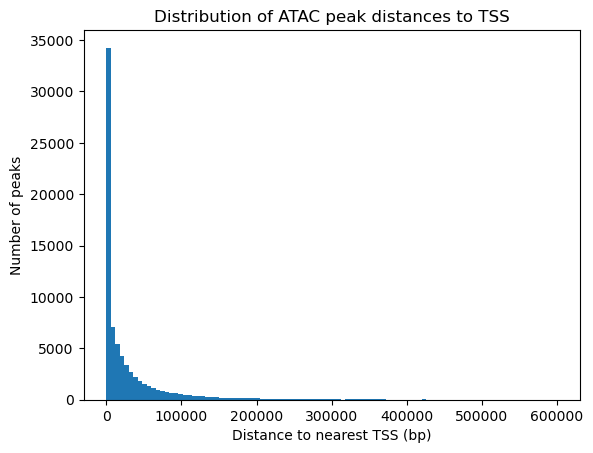

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─── Step 1: Load the RefFlat Gene Annotation File ─────────────────────────────
ref = pd.read_csv("refFlat", sep="\t", header=None)
ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# ─── Step 2: Extract the Strand‐Aware TSS ───────────────────────────────────────
ref["tss"] = ref.apply(
    lambda r: r["tx_start_5prime"] if r["strand"] == "+" else r["tx_start_3prime"],
    axis=1
)

# ─── Step 3: Create the TSS Table ───────────────────────────────────────────────
tss_table = ref[["chrom", "tss"]].copy()

# ─── Step 4: Load the Filtered ATAC Peaks ───────────────────────────────────────
peaks = pd.read_csv("ATAC_high_var.csv")

# Rename your key columns for simplicity:
peaks = peaks.rename(columns={
    "ImmGenATAC1219.peakID": "peak_id",
    "Summit":               "peak_center"
})

# Quick sanity check:
print(peaks[["peak_id", "chrom", "peak_center"]].head())


# ─── Step 5: Build Fast Lookup for Each Chromosome’s TSSs ─────────────────────
tss_dict = {
    chrom: np.sort(group["tss"].values)
    for chrom, group in tss_table.groupby("chrom")
}

# ─── Step 6: Closest‐TSS Finder (Binary Search) ────────────────────────────────
def fast_closest_tss(chrom, center):
    """Return the nearest TSS (in bp) on chromosome `chrom` to position `center`."""
    if chrom not in tss_dict:
        return np.nan
    arr = tss_dict[chrom]
    idx = np.searchsorted(arr, center)
    # edge cases
    if idx == 0:
        return arr[0]
    if idx == len(arr):
        return arr[-1]
    # choose nearer of the two flanking positions
    left, right = arr[idx-1], arr[idx]
    return left if abs(center-left) < abs(center-right) else right

# ─── Step 7: Apply to All Peaks & Compute Distance ─────────────────────────────
peaks["closest_tss"]    = peaks.apply(
    lambda r: fast_closest_tss(r["chrom"], r["peak_center"]),
    axis=1
)
peaks["distance_to_tss"] = np.abs(peaks["peak_center"] - peaks["closest_tss"])

# ─── Step 8: Histogram of Distances ────────────────────────────────────────────
plt.hist(peaks["distance_to_tss"].dropna(), bins=100, range=(0, 600000))
plt.xlabel("Distance to nearest TSS (bp)")
plt.ylabel("Number of peaks")
plt.title("Distribution of ATAC peak distances to TSS")
plt.show()


In [14]:
import pandas as pd

# ─── Step 1: Load the filtered ATAC peaks again ────────────────────────────────
peaks_full = pd.read_csv("ATAC_high_var.csv")

# ─── Rename for clarity ────────────────────────────────────────────────────────
peaks_full = peaks_full.rename(columns={
    "ImmGenATAC1219.peakID": "peak_id",
    "Summit":                "peak_center"
})

# ─── Step 2: Compute mean signal across all the per-cell-type columns ─────────
# Exclude metadata columns so we only average the real signal columns:
_exclude = {
    "peak_id","chrom","peak_center",
    "mm10.60way.phastCons_scores",
    "_-log10_bestPvalue",
    "Included.in.systematic.analysis",
    "TSS","genes.within.100Kb",
    "variance"
}
signal_cols = [c for c in peaks_full.columns if c not in _exclude]

print("Detected signal columns:\n", signal_cols)
peaks_full["mean_signal"] = peaks_full[signal_cols].mean(axis=1)

# Preview
print(peaks_full[["peak_id","chrom","peak_center","mean_signal"]].head())


Detected signal columns:
 ['preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM']
                  peak_id chrom  peak_center  mean_signal
0  ImmGenATAC1219.peak_69  chr1      4468579     3.650690
1  ImmGenATAC1219.peak_77  chr1      4490652    10.661379
2  ImmGenATAC1219.peak_83  chr1      4496479    20.375862
3  ImmGenATAC1219.peak_84  chr1      4496738    11.092414
4  ImmGenATAC1219.peak_93  chr1      4547574     3.159310


In [15]:
peaks_full = pd.read_csv("ATAC_high_var.csv")\
    .rename(columns={
        "ImmGenATAC1219.peakID":"peak_id",
        "Summit":"peak_center"
    })
# signal_cols computed previously…
peaks_full["mean_signal"] = peaks_full[signal_cols].mean(axis=1)


In [16]:
peaks_mean_clean = peaks_full[[
    "peak_id", "chrom", "peak_center", "mean_signal"
]].copy()

print(peaks_mean_clean.head())


                  peak_id chrom  peak_center  mean_signal
0  ImmGenATAC1219.peak_69  chr1      4468579     3.650690
1  ImmGenATAC1219.peak_77  chr1      4490652    10.661379
2  ImmGenATAC1219.peak_83  chr1      4496479    20.375862
3  ImmGenATAC1219.peak_84  chr1      4496738    11.092414
4  ImmGenATAC1219.peak_93  chr1      4547574     3.159310


In [17]:
# peaks was your Task 1 result with peak_id, distance_to_tss
peaks_mean_clean = peaks_mean_clean.merge(
    peaks[["peak_id","distance_to_tss"]],
    on="peak_id",
    how="left"
)
print(peaks_mean_clean.head())
print("Any missing distances?", peaks_mean_clean["distance_to_tss"].isna().sum())


                  peak_id chrom  peak_center  mean_signal  distance_to_tss
0  ImmGenATAC1219.peak_69  chr1      4468579     3.650690          28775.0
1  ImmGenATAC1219.peak_77  chr1      4490652    10.661379           6702.0
2  ImmGenATAC1219.peak_83  chr1      4496479    20.375862            875.0
3  ImmGenATAC1219.peak_84  chr1      4496738    11.092414            616.0
4  ImmGenATAC1219.peak_93  chr1      4547574     3.159310          50220.0
Any missing distances? 7


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_87542/708487228.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


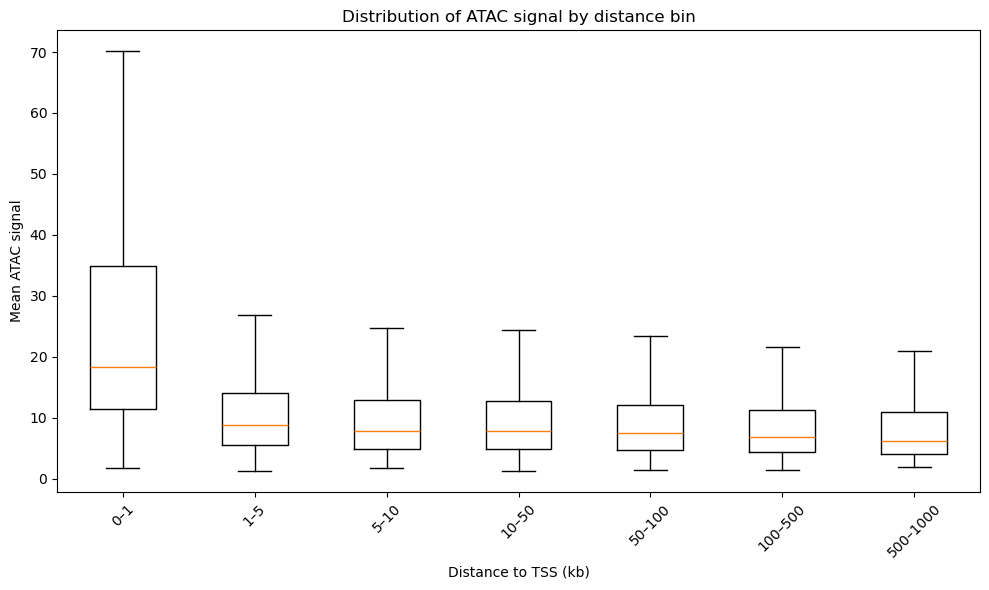

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Prepare
df = peaks_mean_clean.copy()
df["dist_kb"] = df["distance_to_tss"] / 1e3

# define bins in kb
bins = [0,1,5,10,50,100,500,1000]
labels = ["0–1","1–5","5–10","10–50","50–100","100–500","500–1000"]
df["bin"] = pd.cut(df["dist_kb"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
# boxplot of mean_signal per bin
plt.boxplot(
    [df.loc[df["bin"]==lbl, "mean_signal"] for lbl in labels],
    labels=labels,
    showfliers=False
)
plt.xlabel("Distance to TSS (kb)")
plt.ylabel("Mean ATAC signal")
plt.title("Distribution of ATAC signal by distance bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




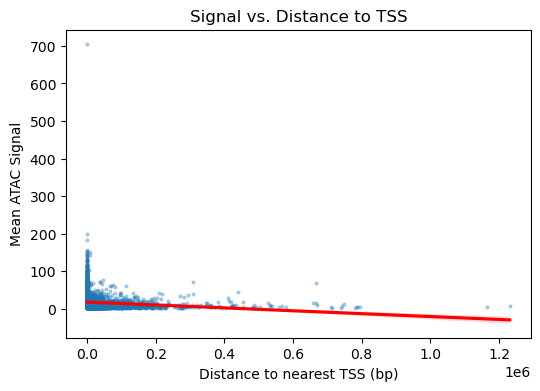

In [31]:
import seaborn as sns

# sample 5k points if needed
sampled = (
    peaks_mean_clean.sample(n=5000, random_state=0)
    if len(peaks_mean_clean) > 5000
    else peaks_mean_clean
)

plt.figure(figsize=(6,4))
sns.regplot(
    data=sampled,
    x="distance_to_tss",
    y="mean_signal",
    scatter_kws={"s":4, "alpha":0.3},
    line_kws={"color":"red"}
)
plt.xlabel("Distance to nearest TSS (bp)")
plt.ylabel("Mean ATAC Signal")
plt.title("Signal vs. Distance to TSS")
plt.show()


In [19]:
from scipy.stats import pearsonr

filtered = peaks_mean_clean.dropna(subset=["distance_to_tss","mean_signal"])
r, pval = pearsonr(filtered["distance_to_tss"], filtered["mean_signal"])
print(f"Pearson r = {r:.4f}, p = {pval:.2e},  R² = {r**2:.4f}")


Pearson r = -0.1603, p = 0.00e+00,  R² = 0.0257


Distance only explains about 2.6 % of the variance in signal. In other words, while peaks nearer TSS tend to be a bit stronger on average, most of the variability in signal comes from other factors (chromatin state, local TF binding, enhancer activity, etc.).

Biological takeaway
There is a trend: promoters and nearby regulatory elements (within a few kb) are typically more accessible.

But the effect is small. Most of your ATAC signal strength is driven by cell‐type–specific factors, local sequence context, and high-order chromatin architecture rather than just “how far is it from the nearest gene start.”

Next steps you might consider
Bin & compare: Group peaks into distance bins (e.g. 0–1 kb, 1–10 kb, 10–100 kb, >100 kb) and plot mean ± SEM signal per bin to see non-linear patterns.

Stratify by feature: Compare promoter-proximal vs. distal peaks, or overlap with known enhancers, to see if certain classes drive stronger signals.

Add more covariates: Incorporate GC content, conservation scores, or specific histone marks if you have them—to see what else explains signal variation.